In [89]:
#!/usr/bin/env python
# coding: utf-8

# In[29]:


# pip install nashpy

In [90]:
# In[30]:

import import_ipynb

In [91]:
# In[31]:

import numpy as np
import nashpy as ns
from itertools import permutations
import lemkeHowson1 as lemkeHowson
import matrix
import rational
import multiprocessing
import matplotlib.pyplot as plt

In [92]:
# In[32]:

u = 1
t = 0.5
beta = 0.5
q = 1.3
lambda_ = 0.2
delta = 0.3
big_A = 2
eta = 0 # state location
WORLD_HEIGHT = 100
WORLD_WIDTH = 100

# possible actions
ACTION_UP = 0
ACTION_DOWN = 1
ACTION_STOP = 2

# 建座標平面
gridIndexList = []
for i in range(0, WORLD_HEIGHT+1):
    gridIndexList.append(i)

actions = [ACTION_UP, ACTION_DOWN]
statesAllOne = []
locationValidActions = {}
history_state_agent0 = []
history_state_agent1 = []
resagentStateList={}
resrewardList={}
resdemandList={}
resState={}
resreward={}
resdemand={}

# 建立state的所有可能(有兩個agent)
for i in permutations(gridIndexList, 2):
    statesAllOne.append(i)

for i in range(WORLD_HEIGHT+1):
    statesAllOne.append((i, i))

for i in gridIndexList:
    locationValidActions[i] = []

# 每個位置皆有自己的action可能
for i in range(0, WORLD_HEIGHT+1):
    gridIndexNumber = i
    if i != WORLD_HEIGHT:
        locationValidActions[gridIndexNumber].append(ACTION_UP)
    if i != 0:
        locationValidActions[gridIndexNumber].append(ACTION_DOWN)
    locationValidActions[gridIndexNumber].append(ACTION_STOP)

In [93]:
# In[33]:

class agent:
    def __init__(self, agentIndex = 0, startLocationIndex = 0):
        self.epsilon = 1.0
        self.goalState = ()
        self.qTable = {}
        self.timeNumber = {}
        self.alpha = {}
        # self.singleQValue = {}
        # self.singleAlpha = {}
        self.currentState = ()
        self.nextState = ()
        self.strategy = {}
        self.agentIndex = agentIndex
        self.startLocationIndex = startLocationIndex
        self.locationIndex = startLocationIndex
        self.currentAction = 0
        self.currentReward = 0
        self.timeStep = 0


    # This is not necessary in this experiment
    def initialSelfStrategy(self):
        for i in statesAllOne:
            self.strategy[i] = {}
            for j in locationValidActions[i[self.agentIndex]]:
                #i here is the combination of two agents' location index
                #agentIndex represents the agent number
                #initial the strategy, the probability of all action is 0
                self.strategy[i][j] = 0

    def initialSelfQTable(self):
        # agent0 and agnet1
        # each agent keeps two tables: one for himself and for the opponent
        # in Qtable, agent also can observe his opponent's action
        self.qTable[0] = {}
        self.qTable[1] = {}
        for i in statesAllOne:
            self.qTable[0][i] = {}
            self.qTable[1][i] = {}
            for j_1 in locationValidActions[i[0]]:
                for j_2 in locationValidActions[i[1]]:
                    self.qTable[0][i][(j_1, j_2)] = 0
                    self.qTable[1][i][(j_1, j_2)] = 0

    def initialSelfAlpha(self):
        # account the visiting number of each combination of states and actions
        for i in statesAllOne:
            self.alpha[i] = {}
            self.timeNumber[i] = {}
            for j_1 in locationValidActions[i[0]]:
                for j_2 in locationValidActions[i[1]]:
                    self.alpha[i][(j_1, j_2)] = 0
                    self.timeNumber[i][(j_1, j_2)] = 0
                    
    def update_epsilon(self):
        self.epsilon = self.epsilon * 0.999
        if self.epsilon < 0.01:
            self.epsilon = 0.01

    # def initialSingleQValue(self):
    #     for i in statesAllOne:
    #         self.singleQValue[i] = {}
    #         for j in locationValidActions[i[self.agentIndex]]:
    #             self.singleQValue[i][j] = 0
    #
    # def initialSingleAlpha(self):
    #     for i in statesAllOne:
    #         self.singleAlpha[i] = {}
    #         for j in locationValidActions[i[self.agentIndex]]:
    #             self.singleAlpha[i][j] = 0

    # def chooseActionWithEpsilon(self, EPSILON, currentState):
    #     self.locationIndex = currentState[self.agentIndex]
    #     if np.random.binomial(1, self.EPSILON) == 1:
    #         self.currentAction = np.random.choice(locationValidActions[self.locationIndex])
    #     else:
    #         # it is a method to find the max value in a dict and the corresponding key
    #         self.currentAction = max(zip(self.singleQValue[self.currentState].values(), self.singleQValue[self.currentState].keys()))[1]


    def constructPayoffTable(self, state):
        # construct Payoff Table for agent 0 and agent 1
        # actions0 and actions1 are list for invalid actions
        # the content of Payoff Table is the Q value
        # 每個state的各個agent的各自action轉換成矩陣
        actions0 = locationValidActions[state[0]]
        actions1 = locationValidActions[state[1]]
        m0 = matrix.Matrix(len(actions0), len(actions1))
        m1 = matrix.Matrix(len(actions0), len(actions1))
        for i in range(len(actions0)):
            for j in range(len(actions1)):
                m0.setItem(i+1, j+1, self.qTable[0][state][(actions0[i], actions1[j])])
                m1.setItem(i+1, j+1, self.qTable[1][state][(actions0[i], actions1[j])])
        return (m0, m1)

    def nashQLearning(self, gamma, agent0Action, agent0Reward, currentState, nextState, agent1Action, agent1Reward):
        self.gamma = gamma
        self.currentState = currentState
        self.nextState = nextState
        # 這個state中每個agent做action的次數
        self.timeNumber[self.currentState][(agent0Action, agent1Action)] += 1
        self.alpha[self.currentState][(agent0Action, agent1Action)] = 1.0 / self.timeNumber[self.currentState][(agent0Action, agent1Action)]
        # m0 and m1 are payoff tables of agent0 and agent1 (based on Qvalue table)
#         print('state: ', currentState, 'agent0Action: ', agent0Action, 'agent1Action: ', agent1Action)
        (m0, m1) = self.constructPayoffTable(nextState)
#         print('m0, m1', m0, m1)
        probprob = lemkeHowson.lemkeHowson(m0, m1)
#         print("probprob", probprob)
        prob0 = np.array(probprob[0])
        prob1 = np.array(probprob[1])
        prob0 = np.matrix(prob0)
        prob1 = np.matrix(prob1).reshape((-1, 1))
        # calculate the nash values
        m_m0 = []
        m_m1 = []
        for i in range(m0.getNumRows()):
            for j in range(m0.getNumCols()):
                m_m0.append(m0.getItem(i+1, j+1))
        for i in range(m1.getNumRows()):
            for j in range(m1.getNumCols()):
                m_m1.append(m1.getItem(i+1, j+1))
        m_m0 = np.matrix(m_m0).reshape((m0.getNumRows(), m0.getNumCols()))
        m_m1 = np.matrix(m_m1).reshape((m1.getNumRows(), m1.getNumCols()))
        m_nash0 = prob0 * m_m0 * prob1
        m_nash1 = prob0 * m_m1 * prob1
        nash0 = m_nash0[0, 0].nom() / m_nash0[0, 0].denom()
        nash1 = m_nash1[0, 0].nom() / m_nash1[0, 0].denom()
        nashQValues = [nash0, nash1]
        self.qTable[0][self.currentState][(agent0Action, agent1Action)]             = (1 - self.alpha[self.currentState][(agent0Action, agent1Action)])                 * self.qTable[0][self.currentState][(agent0Action, agent1Action)]                     + self.alpha[self.currentState][(agent0Action, agent1Action)]                         * (agent0Reward + self.gamma * nashQValues[0])
        self.qTable[1][self.currentState][(agent0Action, agent1Action)]             = (1 - self.alpha[self.currentState][(agent0Action, agent1Action)])                 * self.qTable[1][self.currentState][(agent0Action, agent1Action)]                     + self.alpha[self.currentState][(agent0Action, agent1Action)]                         * (agent1Reward + self.gamma * nashQValues[1])
#         print(self.qTable[0][self.currentState][(agent0Action, agent1Action)] == self.qTable[1][self.currentState][(agent0Action, agent1Action)])
        self.timeStep += 1

    def chooseActionBasedOnQTable(self, currentState):
        self.locationIndex = currentState[self.agentIndex]
        (m0, m1) = self.constructPayoffTable(currentState)
        probprob = lemkeHowson.lemkeHowson(m0, m1)
        prob0 = np.array(probprob[0])
        re0 = np.where(prob0 == np.max(prob0))[0][0]
        prob1 = np.array(probprob[1])
        re1 = np.where(prob1 == np.max(prob1))[0][0]
        re = [re0, re1]
        actionsAvailable = locationValidActions[currentState[self.agentIndex]]
        return actionsAvailable[re[self.agentIndex]]
    
    def chooseActionRandomly(self, currentState):
        # choose action randomly based on current location
        if np.random.uniform() < self.epsilon:
            self.locationIndex = currentState[self.agentIndex]
            self.currentAction = np.random.choice(locationValidActions[self.locationIndex])
#             self.update_epsilon()
#             print(self.epsilon)
        else:
            self.currentAction = np.random.choice(locationValidActions[self.locationIndex])
#             self.currentAction = self.chooseActionBasedOnQTable(currentState)
            
        return self.currentAction
    
    def chooseActionBasedOnQTableRandomly(self, currentState):
        # choose action randomly based on current location
        if np.random.uniform() < 0.05:
            self.locationIndex = currentState[self.agentIndex]
            self.currentAction = np.random.choice(locationValidActions[self.locationIndex])
#             self.update_epsilon()
#             print(self.epsilon)
        else:
#             self.currentAction = np.random.choice(locationValidActions[self.locationIndex])
            self.currentAction = self.chooseActionBasedOnQTable(currentState)
            
        return self.currentAction

In [94]:
# In[34]:

def nextGridIndex(action, gridIndex):
    action = action
    index_i = gridIndex
    if (action == 0): # 0 = +1
        index_i += 1
    elif (action == 1): # 1 = -1
        index_i -= 1
    # 2 = 不動，所以不用判斷直接回傳
    nextIndex = index_i
    return nextIndex

In [95]:
# In[35]:

def gridGameOne(action_0, action_1, currentState, count, agent_0, agent_1, cb):
    action_0 = action_0
    action_1 = action_1
    agent_0 = agent_0
    agent_1=agent_1
    currentState = currentState
    reward_0 = 0
    reward_1 = 0
    endGameFlag = 0

    currentIndex_0 = currentState[0] # agent 0's current location
    currentIndex_1 = currentState[1] # agent 1's current location
    nextIndex_0 = nextGridIndex(action_0, currentState[0]) # agent 0's next location
    nextIndex_1 = nextGridIndex(action_1, currentState[1]) # agent 1's next location

    # construct payoff table for agent 0 and agent 1 and test if there's nash equilibrium
    (m0, m1) = agent_0.constructPayoffTable((nextIndex_0, nextIndex_1))
    testlemkeHowson_agent0 = lemkeHowson.testlemkeHowson(m0, m1)
    (m0, m1) = agent_1.constructPayoffTable((nextIndex_0, nextIndex_1))
    testlemkeHowson_agent1 = lemkeHowson.testlemkeHowson(m0, m1)

    alpha = round(nextIndex_0/100,2) 
    p = round(nextIndex_1/100,2)
   
    theta_bar = (u - beta * alpha) / t
    theta_hat = (t - lambda_ + (1 - q) * u - beta * alpha + p) / (2*t - lambda_)
    theta_uline = (2 * t * t + (-2 * q * u + 2 * p - 2 * lambda_)*t + lambda_ * (u - beta * alpha)) / (t * (2 * t - lambda_))
    Ng=0
    if (theta_bar >= 0 and theta_bar <= 1):
        Ng = theta_hat + delta * (theta_bar - theta_hat)
    else:
        Ng = theta_hat + delta * (1 - theta_hat)
    
    Nc = 1 - theta_hat
    U_google = u - t * theta_hat - beta * alpha
    U_chatgpt = q * u + lambda_ * Nc - t * (1 - theta_hat) - p
    
#     if testlemkeHowson_agent0==False or testlemkeHowson_agent1==False:
#         print(currentState, (nextIndex_0, nextIndex_1), testlemkeHowson_agent0, testlemkeHowson_agent1)
# 超過邊界或是效用為0都不成立
    
    if (nextIndex_0 < 0 or nextIndex_1 < 0) or (nextIndex_0 > WORLD_HEIGHT or nextIndex_1 > WORLD_WIDTH) or U_google < 0 or U_chatgpt < 0 or (theta_bar < theta_hat) or theta_hat < theta_uline or (theta_hat < 0 or theta_hat > 1):
        reward_0 = -200
        reward_1 = -200
        cb += 1
        if testlemkeHowson_agent0==False or testlemkeHowson_agent1==False:
            print("false",end="")
            reward_0=0
            reward_1=0
        if (cb > 40):
            print(f"40, state=({currentIndex_0},{currentIndex_1})",end=" ")
            cb=0
            nextState = (nextIndex_0, nextIndex_1)
        else:
            nextState = (currentIndex_0, currentIndex_1)
        
# #       還要減去(x係數減y係數)
#         if 2*(K-beta*sigma*phi)*currentIndex_0-K*currentIndex_1 >= delta*K+t*(K-beta*sigma)-(2*(K-beta*sigma*phi)-K) and \
#             (beta*sigma*phi-K)*currentIndex_0+2*K*currentIndex_1 >= delta*K+t*(beta*sigma-K)+K*beta*M-((beta*sigma*phi-K)+2*K):
#             endGameFlag = 1
#             reward_0 = 10
#             reward_1 = 10
        
    else:
#         theta = ((delta+t+nextIndex_1-nextIndex_0)*K+beta*sigma*phi*nextIndex_0-beta*sigma*t)/((2*delta+beta*M)*K)
#         d_a=(phi*nextIndex_0-t)/K
#         U_uber = V-delta*theta-beta*(theta*M-sigma*d_a)-nextIndex_0
#         U_buget = V-delta*(1-theta)-t-nextIndex_1
        r0 = alpha * (big_A - alpha) * Ng
        r1 = p * Nc
        # r1 = (1-phi)*nextIndex_0*theta*M
        # if eta >= (1-theta)*M:
            # r2 = nextIndex_1*(1-theta)*M-c*eta
        # else:
#             r2 = 0
            # r2 = nextIndex_1*eta-c*eta
        count += 1
        cb = 0
        reward_0 = round(r0,4)
        reward_1 = round(r1,4)
#         if r1 < 0 or r2 < 0:
#             reward_0 = -10
#             reward_1 = -10
#         elif r1 > 0 and r2 < 0:
#             reward_1 = -10
#         elif r1 < 0 and r2 > 0:
#             reward_0 = -10
                
        nextState = (nextIndex_0, nextIndex_1)
    
    if count > 6000:
        endGameFlag = 1
        print(f"cd : {cb}",end=" ")
        cb = 0
        
    return reward_0, reward_1, nextState, count, endGameFlag, round(Ng,5), round(Nc,5), cb

In [96]:
# In[36]:

def resetStartState():
#     print(history_state_agent0)
#     newLocationIndex = np.random.choice(len(history_state_agent0))
#     agent_0LocationIndex = history_state_agent0[newLocationIndex][0]
#     agent_1LocationIndex = history_state_agent0[newLocationIndex][1]
#     return (agent_0LocationIndex, agent_1LocationIndex)
    return (0, 0)

In [97]:
import random
def resetStartStateRandomly():
    agent_0LocationIndex = random.randint(0, 100)
    agent_1LocationIndex = random.randint(0, 100)
    return (agent_0LocationIndex, agent_1LocationIndex)

In [98]:
# In[37]:

def playGameOne(agent_0 = agent, agent_1 = agent):
    gamma = 0.9
    agent_0 = agent_0
    agent_1 = agent_1
    count = 0
    cb = 0
    currentState = (agent_0.startLocationIndex, agent_1.startLocationIndex)
    timeStep = 0 # calculate the timesteps in one episode
    episodes = 0
    endGameFlag = 0
    agent_0.initialSelfQTable()
    agent_1.initialSelfQTable()
    agent_0.initialSelfAlpha()
    agent_1.initialSelfAlpha()
    while episodes < 100:
        new = 0
#         print (episodes)
        while new == 0:
            agent0Action = agent_0.chooseActionRandomly(currentState)
            agent1Action = agent_1.chooseActionRandomly(currentState)
            reward_0, reward_1, nextState, count, endGameFlag, Ng, Nc, cb= gridGameOne(agent0Action, agent1Action, currentState, count, agent_0, agent_1, cb)
#             print(currentState, nextState)
            agent_0.nashQLearning(gamma, agent0Action, reward_0, currentState, nextState, agent1Action, reward_1)
            if currentState not in history_state_agent0:
                history_state_agent0.append(currentState)
            agent_1.nashQLearning(gamma, agent0Action, reward_0, currentState, nextState, agent1Action, reward_1)
#             if currentState[0] > 13 and currentState[1] > 13:
#                 print('currentState: ', currentState)
            currentState = nextState
            if (endGameFlag == 1): # one episode of the game is end
                episodes += 1
                currentState = resetStartState()
                count = 0
#                 agent_0.epsilon = 1.0
#                 agent_1.epsilon = 1.0
                new = 1

In [99]:
# In[38]:

runs = 0
agentActionListEveryRun = {}

# agent_0 = agent(agentIndex=0, startLocationIndex=0)
# agent_1 = agent(agentIndex=1, startLocationIndex=2)
# playGameOne(agent_0, agent_1)
# agentActionListEveryRun[runs] = test(agent_0, agent_1)
# print (agentActionListEveryRun)

# for runs in range(50):
#     agent_0 = agent(agentIndex=0, startLocationIndex=0)
#     agent_1 = agent(agentIndex=1, startLocationIndex=2)
#     playGameOne(agent_0, agent_1)
#     agentActionListEveryRun[runs] = test(agent_0, agent_1)
#     print (runs)
# nashnum = 0
# for runs in range(50):
#     if agentActionListEveryRun[runs][4] == (8, 6):
#         nashnum += 1
# print (agentActionListEveryRun)
# print (nashnum)

# 需要判斷起點從哪一點開始
# start=int((delta*K+t*(K-beta*sigma))/(2*(K-beta*sigma*phi)))
agent_0 = agent(agentIndex=0, startLocationIndex=eta)
agent_1 = agent(agentIndex=1, startLocationIndex=eta)

In [100]:
# In[39]:

def test (agent_0 = agent, agent_1 = agent):
    agent_0 = agent_0
    agent_1 = agent_1
    startState = (0, 0)
    endGameFlag = 0
    runs = 0
    count = 0
    cb = 0
    agentActionList = []
    agentStateList=[]
    rewardList = []
    demandList = []
    finalState=()
    finalreward=()
    finalDemad=()
    currentState = startState
    endGameFlag = 0
    while endGameFlag != 1:
        agent0Action = agent_0.chooseActionBasedOnQTableRandomly(currentState)
        agent1Action = agent_1.chooseActionBasedOnQTableRandomly(currentState)
        agentActionList.append([agent0Action, agent1Action])
        reward_0, reward_1, nextState, count, endGameFlag, Ng, Nc, cb = gridGameOne(agent0Action, agent1Action, currentState, count, agent_0, agent_1, cb)
        agentStateList.append(currentState)
        rewardList.append((reward_0, reward_1))
        demandList.append((Ng, Nc))
        currentState = nextState
#         print(currentState)
    agentStateList.append(currentState)
    finalState=currentState
    finalreward = (rewardList[-1][0],rewardList[-1][1])
    finaldemand = (demandList[-1][0],demandList[-1][1])
    print(currentState)
    return agentActionList, agentStateList, finalState ,rewardList , finalreward, demandList, finaldemand

In [101]:
# In[40]:

def rungame (agent_0 = agent, agent_1 = agent):
    agent_0 = agent_0
    agent_1 = agent_1
    playGameOne(agent_0, agent_1)
#     print('-----------------------------------------------------------')
#     print('test: ')
    runGameResult, agentStateList, finalState, rewardlist, finalreward, demandList, finaldemand= test(agent_0, agent_1)
#     print(runGameResult)
    return runGameResult, agentStateList, finalState, rewardlist, finalreward, demandList, finaldemand

In [102]:
# In[41]:

if __name__ == "__main__":
    # playGameOne(agent_0, agent_1)
    pool = multiprocessing.Pool(processes=10)
    for i in range(12, 16):
        q = i / 100*2+1 
        print(f"q:{q}")
        agent_0 = agent(agentIndex=0, startLocationIndex=0)
        agent_1 = agent(agentIndex=1, startLocationIndex=0)

        agentActionList = []
        agentStateList = []
        finalStateList = []
        rewardlist = []
        finalrewardlist = []
        demandList = []
        finaldemandList = []

        for i in range(3):
            print(i)
            action, state, finalState, reward, finalreward, demand, finaldemand = rungame(agent_0, agent_1)

            agentActionList.append(action)
            agentStateList.append(state)
            finalStateList.append(finalState)
            rewardlist.append(reward)
            finalrewardlist.append(finalreward)
            demandList.append(demand)
            finaldemandList.append(finaldemand)

        resagentStateList[q]=agentStateList #每個eta的agentStateList(在test中每個episode的state)
        resrewardList[q]=rewardlist
        resdemandList[q]=demandList

        print(q, finalStateList)
        print(q, finalrewardlist)
        print(q, finaldemandList)
        
        resState[q]=finalStateList # 每個eta的finalStateList(每個test最後一個停住的state)
        resreward[q]=finalrewardlist
        resdemand[q]=finaldemandList
        
    pool.close()
    pool.join()
    # print (agent_0.qTable[1][3, 6])
    # print (agent_1.qTable[0][8, 5])
    # print (agent_1.qTable[1][8, 5])
#     for res in agentActionList:
#         print(res)
#         print (res.get())

q:1.24
0
cd : 0 cd : 0 cd : 0 cd : 0 cd : 0 cd : 0 cd : 0 cd : 0 cd : 0 cd : 0 cd : 0 cd : 0 cd : 0 cd : 0 cd : 0 cd : 0 cd : 0 cd : 0 cd : 0 cd : 0 cd : 0 cd : 0 cd : 0 cd : 0 cd : 0 cd : 0 cd : 0 cd : 0 cd : 0 cd : 0 cd : 0 cd : 0 cd : 0 cd : 0 cd : 0 cd : 0 cd : 0 cd : 0 cd : 0 cd : 0 cd : 0 cd : 0 cd : 0 cd : 0 cd : 0 cd : 0 cd : 0 cd : 0 cd : 0 cd : 0 cd : 0 cd : 0 cd : 0 cd : 0 cd : 0 cd : 0 cd : 0 cd : 0 cd : 0 cd : 0 cd : 0 cd : 0 cd : 0 cd : 0 cd : 0 cd : 0 cd : 0 cd : 0 cd : 0 cd : 0 cd : 0 cd : 0 cd : 0 cd : 0 cd : 0 cd : 0 cd : 0 cd : 0 cd : 0 cd : 0 cd : 0 cd : 0 cd : 0 cd : 0 cd : 0 cd : 0 cd : 0 cd : 0 cd : 0 cd : 0 cd : 0 cd : 0 cd : 0 cd : 0 cd : 0 cd : 0 cd : 0 cd : 0 cd : 0 cd : 0 cd : 0 (55, 28)
1
cd : 0 cd : 0 cd : 0 cd : 0 cd : 0 cd : 0 cd : 0 cd : 0 cd : 0 cd : 0 cd : 0 cd : 0 cd : 0 cd : 0 cd : 0 cd : 0 cd : 0 cd : 0 cd : 0 cd : 0 cd : 0 cd : 0 cd : 0 cd : 0 cd : 0 cd : 0 cd : 0 cd : 0 cd : 0 cd : 0 cd : 0 cd : 0 cd : 0 cd : 0 cd : 0 cd : 0 cd : 0 cd : 0 cd : 0 

1.3
1.3
1.3


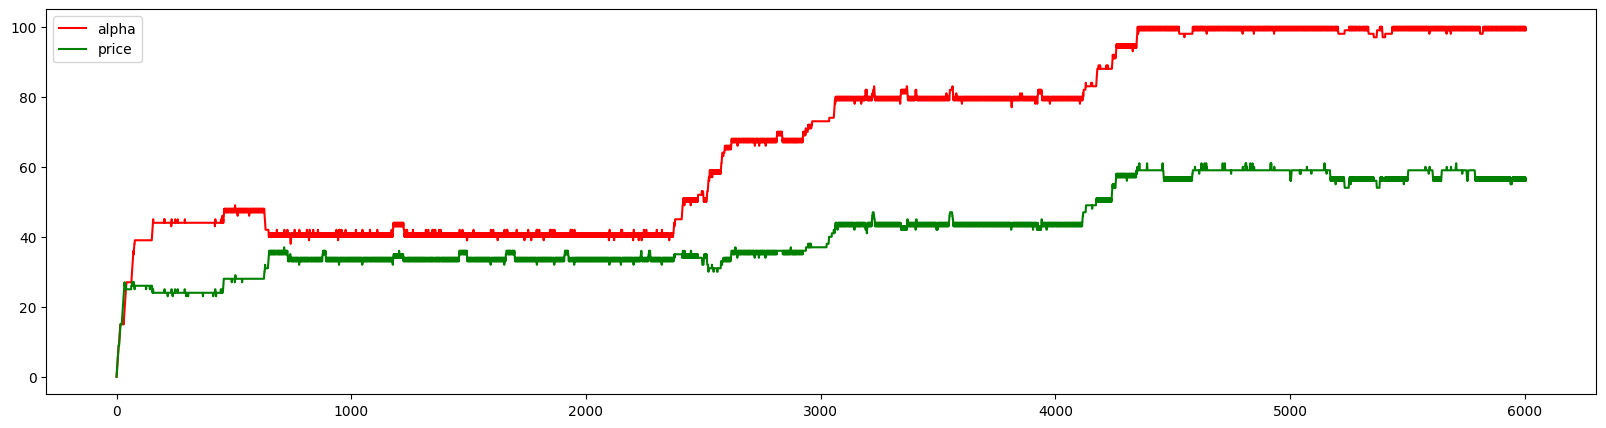

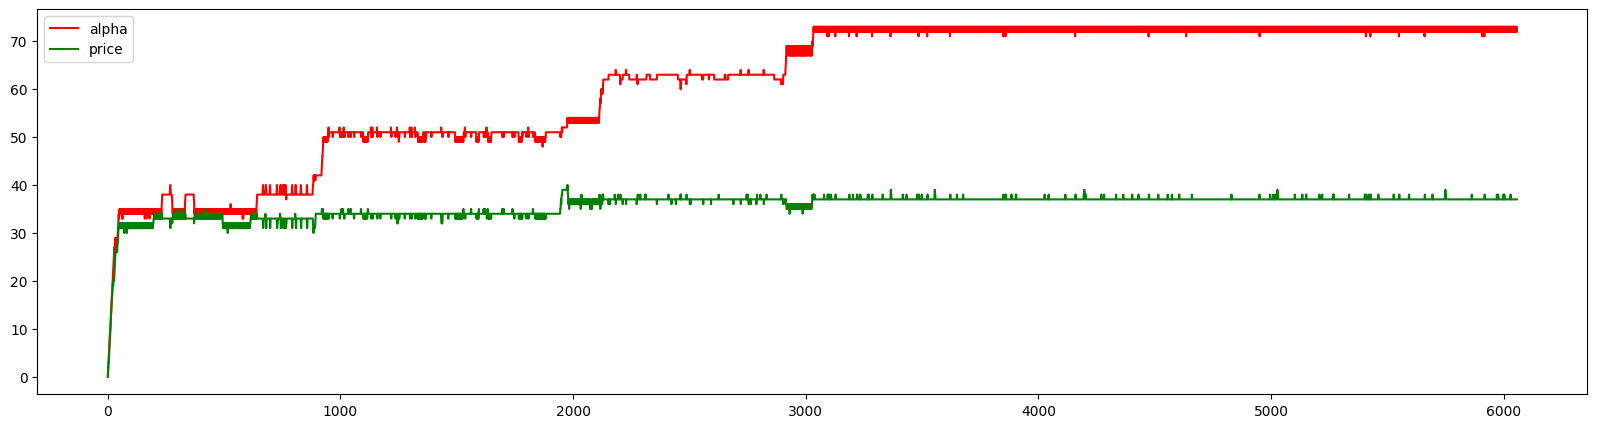

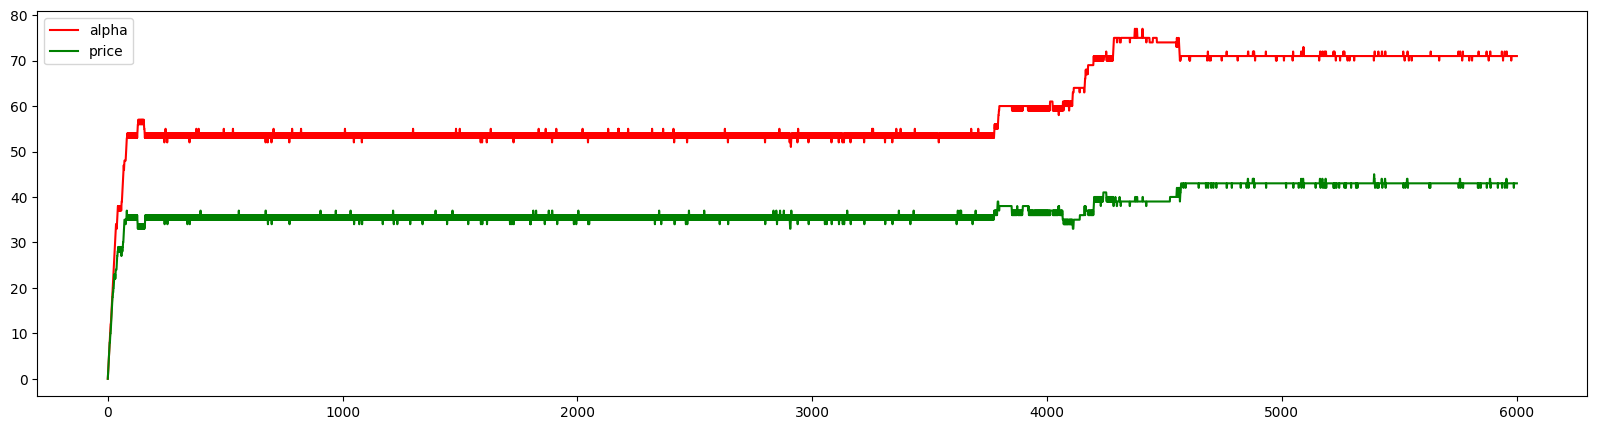

In [103]:
# In[43]:

k=q
for i in range(len(resState[k])): # 17-20 = 4
    alpha = []
    price = []
    print(k)
    eposide = [i for i in range(len(resagentStateList[k][i]))]
    for j in range(len(resagentStateList[k][i])):
        # print(i)
        alpha.append(resagentStateList[k][i][j][0])
        price.append(resagentStateList[k][i][j][1])
    plt.figure(figsize=(20,5))
    plt.plot(eposide, alpha, "r")
    plt.plot(eposide, price, "g")
    plt.legend(labels=['alpha', 'price'])

1.3
1.3
1.3


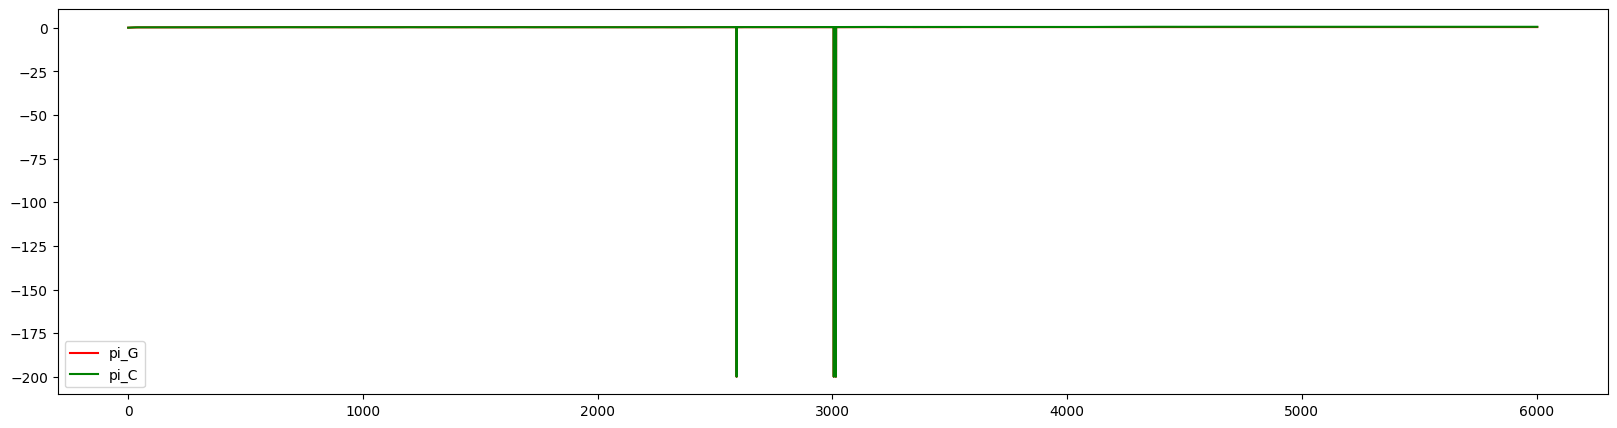

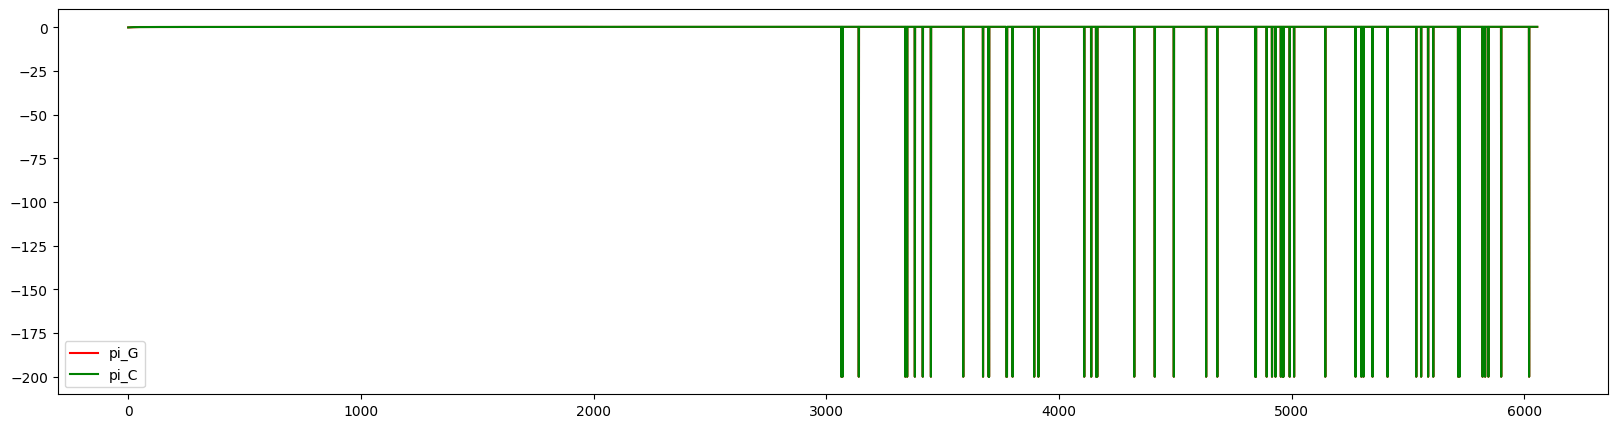

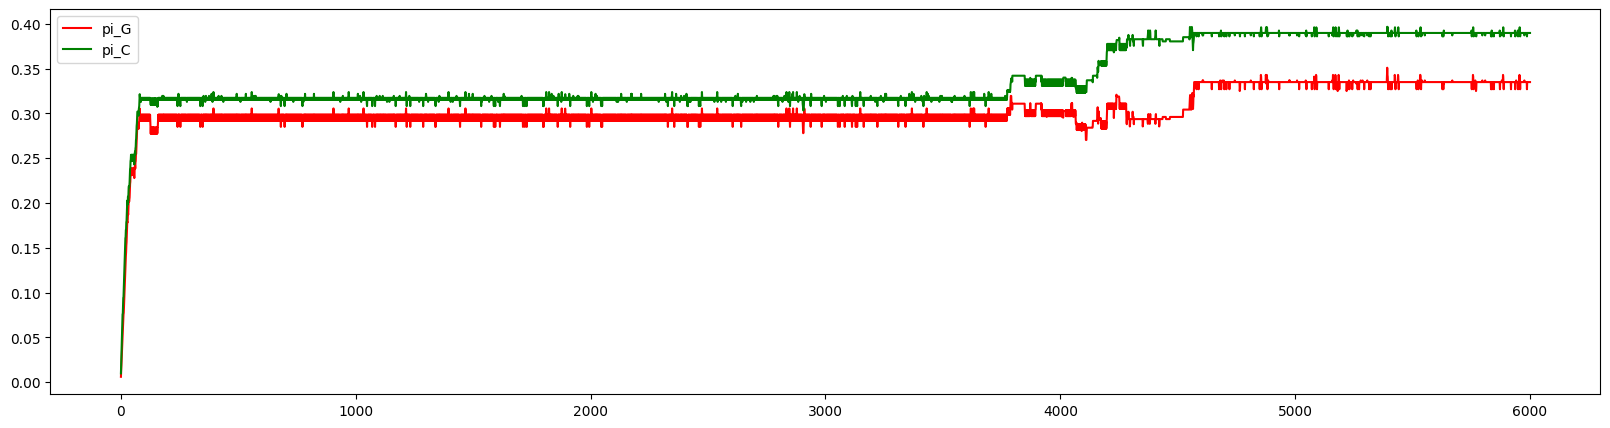

In [104]:
k=q
for i in range(len(resreward[k])): # 17-20 = 4
    pi_G = []
    pi_C = []
    print(k)
    eposide = [i for i in range(len(resrewardList[k][i]))]
    for j in range(len(resrewardList[k][i])):
        # print(i)
        pi_G.append(resrewardList[k][i][j][0])
        pi_C.append(resrewardList[k][i][j][1])
    plt.figure(figsize=(20,5))
    plt.plot(eposide, pi_G, "r")
    plt.plot(eposide, pi_C, "g")
    plt.legend(labels=['pi_G', 'pi_C'])

1.3
1.3
1.3


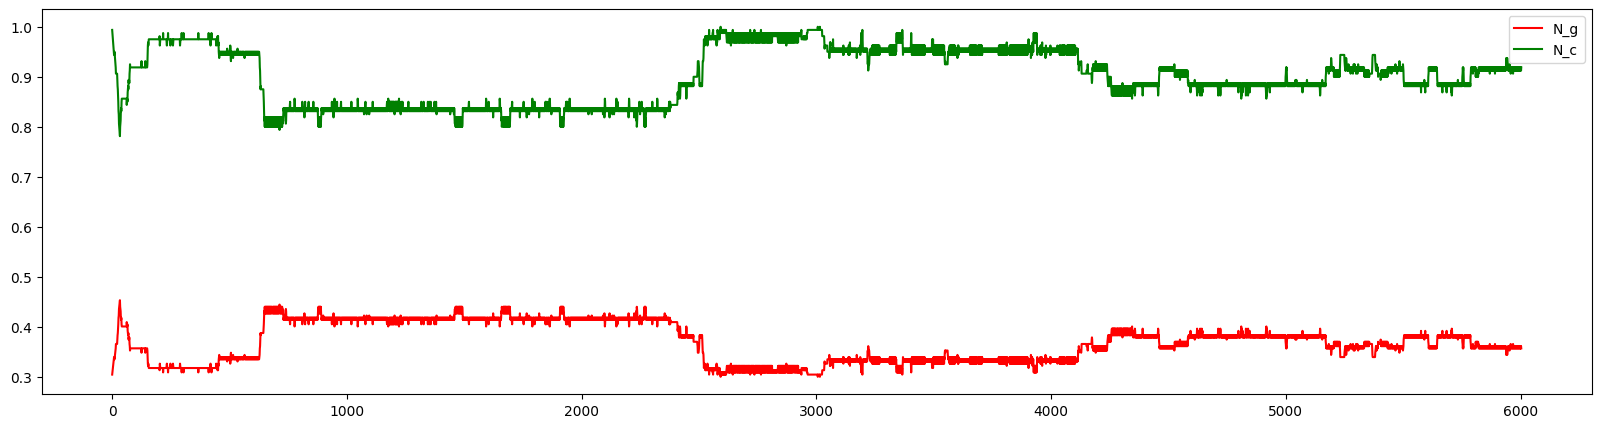

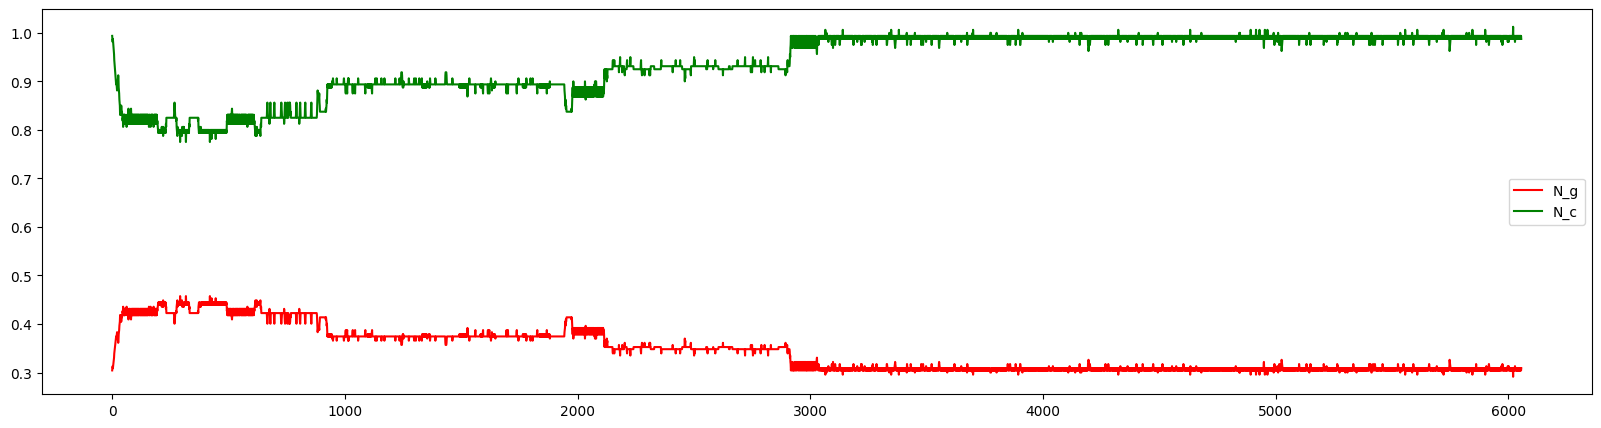

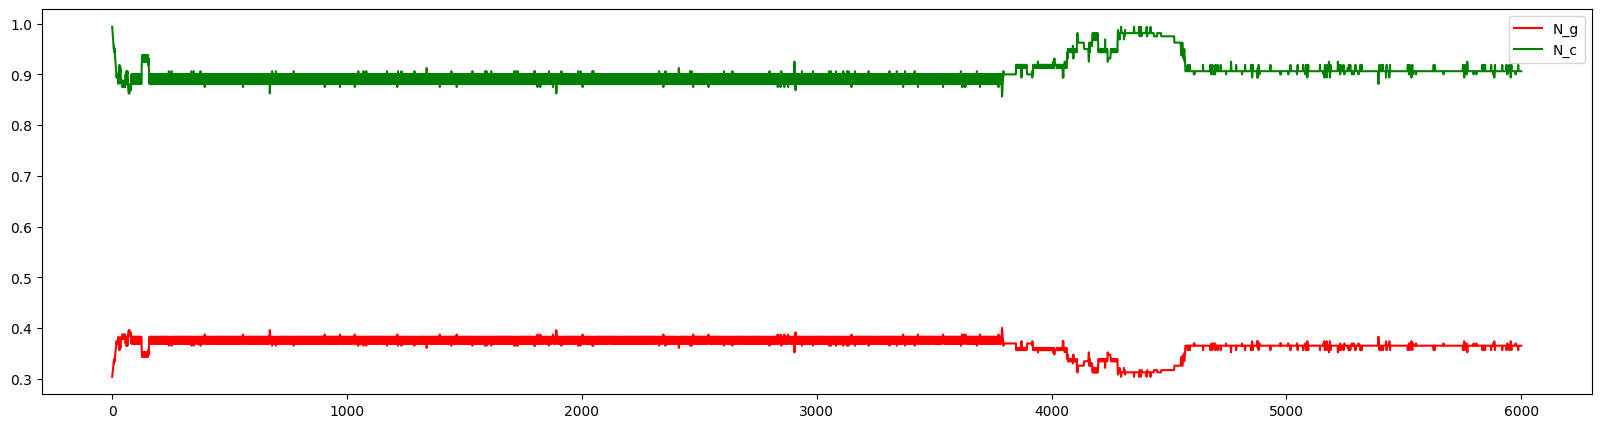

In [105]:
# In[43]:

k=q
for i in range(len(resdemand[k])): # 17-20 = 4
    N_g = []
    N_c = []
    print(k)
    eposide = [i for i in range(len(resdemandList[k][i]))]
    for j in range(len(resdemandList[k][i])):
        # print(i)
        N_g.append(resdemandList[k][i][j][0])
        N_c.append(resdemandList[k][i][j][1])
    plt.figure(figsize=(20,5))
    plt.plot(eposide, N_g, "r")
    plt.plot(eposide, N_c, "g")
    plt.legend(labels=['N_g', 'N_c'])

In [106]:
# In[44]:

import csv
resState_info=['eta', 'pricing']
print(type(resState))
with open('paper_q', 'a+') as f:
    writer=csv.writer(f)
    for k, v in resState.items():
        writer.writerow([k, v[0], v[1], v[2]])

<class 'dict'>


In [107]:

import csv
resState_info=['eta', 'pricing']
print(type(resreward))
with open('paper_q_r', 'a+') as f:
    writer=csv.writer(f)
    for k, v in resreward.items():
        writer.writerow([k, v[0], v[1], v[2]])

<class 'dict'>


In [108]:
import csv
resState_info=['eta', 'pricing']
print(type(resdemand))
with open('paper_q_d', 'a+') as f:
    writer=csv.writer(f)
    for k, v in resdemand.items():
        writer.writerow([k, v[0], v[1], v[2]])

<class 'dict'>
